In [13]:
#Importing the relevant modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import icd
from prince import MCA
import prince
from prince import mca
import scipy.stats as stats
import seaborn as sns
import seaborn

loading in the raw UKBiobank data associated with 2149 leukaemic patients.

In [14]:
sample_df = pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/leu.tsv", sep='\t', header=0, low_memory= 'False')
inferred_dtypes = sample_df.dtypes
dtype_dict = {}
for col, dtype in inferred_dtypes.items():
    dtype_dict[col] = dtype.name
df = pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/leu.tsv", sep='\t', dtype=dtype_dict, engine='python')

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\3597010048.py:1: DtypeWarning: Columns (19,20,21,23,24,25,29,30,31,98,99,100,106,107,108,110,111,451,453,454,478,479,735,736,737,739,740,741,751,752,753,755,756,757,775,776,777,779,780,781,783,784,785,814,815,816,818,819,820,822,823,824,826,827,828,829,830,831,833,834,835,838,839,840,842,843,844,846,847,848,870,871,872,874,875,876,878,879,880,882,883,884,886,887,888,890,891,892,898,899,900,902,903,904,906,907,908,910,911,912,914,915,916,918,919,920,922,923,924,926,927,928,930,931,932,958,959,960,962,963,964,966,967,968,970,971,972,974,975,976,978,979,980,982,983,984,986,987,988,990,991,992,994,995,996,1002,1003,1004,1010,1011,1012,1014,1015,1016,1026,1027,1028,1030,1031,1032,1038,1039,1040,1042,1043,1044,1046,1047,1048,1070,1071,1072,1074,1075,1076,1078,1079,1081,1082,1084,1085,1087,1088,1090,1091,1093,1094,1096,1097,1102,1103,1105,1106,1107,1109,1110,1111,1113,1114,1116,1117,1119,1120,1121,1127,1128,1129,1143,1144,1145,11

Extracting the diagnoses corresponding to specific 3-4 letter ICD-10 codes at various instances (follow up visits) for each patient in the form of a dataframe.

In [15]:
subset_data= pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/subset_data.csv", sep= ',', header= 0)

In [16]:
subset_data= subset_data.set_index('eid')
df = df[df['eid'].isin(subset_data.index)]

In [17]:
icd_columns= df.columns[df.columns.str.contains('f41270_0')]
icd_df= df[['eid'] + list(icd_columns)]

creating a dictionary with the type of leukemia as the key and their assigned ICD-10 code as values. For unspecified myeloid, lymphoid, acute and chronic types, more than one ICD-10 codes were considered.

In [18]:
leukemia_dict= {
    'AML': 'C920',
    'CML': 'C910',
    'ALL': 'C911',
    'CLL': 'C921',
    'ML': ['C92', 'C920', 'C920', 'C921', 'C922', 'C923', 'C924', 'C925', 'C926', 'C927', 'C928', 'C929'],
    'LL':  ['C91', 'C910', 'C910', 'C911', 'C912', 'C913', 'C914', 'C915', 'C916', 'C917', 'C918', 'C919'],
    'Acute': ['C920', 'C910'],
    'Chronic': ['C921', 'C911']}

Creating a function to determine the leukemia type of each patient based on the specific ICD-10 code and storing the information in the leukemia_types_df dataframe

In [19]:
def determine_leukemia_types(row, leukemia_dict):
    result = {}
    for leukemia_type, icd_codes in leukemia_dict.items():
        if isinstance(icd_codes, str):  # Single ICD code
            result[leukemia_type] = icd_codes in str(row.values)
        elif isinstance(icd_codes, list):  # List of ICD codes
            result[leukemia_type] = any(icd_code in str(row.values) for icd_code in icd_codes)
    return result

In [20]:
leukemia_types_list = []
for _, row in icd_df.iterrows():
    leukemia_types_list.append(determine_leukemia_types(row, leukemia_dict))
leukemia_types_df = pd.DataFrame(leukemia_types_list)

# Concatenate the results with the original DataFrame
icd_df = pd.concat([icd_df.reset_index(drop=True), leukemia_types_df.reset_index(drop=True)], axis=1)


In [21]:
#replacing null type values in icd_df with an empty string
icd_df[icd_columns]= icd_df[icd_columns].fillna('').astype(str)

Mapping the icd codes in the icd_df dataframe with broad comorbidities defined by charlson comorbidity index by utilizing the icd package.

In [22]:
comor= icd.icd_to_comorbidities(icd_df, 'eid', icd_columns, mapping="charlson10")

In [23]:
comor= comor.drop(comor.columns[-1], axis=1)

In [24]:
#excluding the ML, LL , Acute and Chronic columns from the leukemia_types_df dataframe.
#resulting in a new leuk_df containing only AML, CML, CLL and ALL patients
leuk_df=leukemia_types_df.drop(columns=['ML'])
leuk_df=leuk_df.drop(columns=['Acute'])
leuk_df=leuk_df.drop(columns=['Chronic'])
leuk_df=leuk_df.drop(columns=['LL'])
leuk_df['eid']= comor.index
leuk_df= leuk_df.set_index('eid')

In [25]:
#merging the leuk_df with the comor dataframe 
comor_unsub= comor.merge(leuk_df[['AML', 'CML', 'ALL', 'CLL']], left_index=True, right_on= 'eid')

Extracting the sex, Index of multiple deprivation score and the age of death (where applicable as not all patients are deceased) from the original df.

In [26]:
sex_df= df[df.columns[df.columns.str.contains('f31_0')]]
sex_df['eid']= comor.index

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\1582115032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sex_df['eid']= comor.index


In [27]:
imd_df= df[df.columns[df.columns.str.contains('f26410')]]
imd_df['eid']= comor.index

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\995309674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imd_df['eid']= comor.index


In [28]:
death_df= df[df.columns[df.columns.str.contains('f40007_0')]]
death_df['eid']= comor.index

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\572413159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_df['eid']= comor.index


Merging the sex, IMD and age of death columns with the comor_unsub dataframe

In [29]:
comor_unsub= comor_unsub.merge(sex_df[['eid', 'sex_f31_0_0']], left_index= True, right_on= 'eid')

In [30]:
comor_unsub= comor_unsub.set_index('eid')

In [31]:
comor_unsub= comor_unsub.merge(imd_df[['eid', 'index_of_multiple_deprivation_england_f26410_0_0']], left_index=True, right_on= 'eid')

In [32]:
comor_unsub= comor_unsub.set_index('eid')

In [33]:
comor_unsub= comor_unsub.merge(death_df[['eid', 'age_at_death_f40007_0_0']], left_index=True, right_on= 'eid')

In [34]:
comor_unsub= comor_unsub.set_index('eid')

In [35]:
#Converting the boolean true/false values to integer 0/1
columns_to_map = comor_unsub.iloc[:, 0:17].columns
for column in columns_to_map:
    comor_unsub[column] = comor_unsub[column].map({True: 1, False: 0})

In [36]:
comor_unsub['sex_f31_0_0']= comor_unsub['sex_f31_0_0'].map({'Male':0, 'Female':1})

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\2112495714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imd_df['log_imd'] = np.log(imd_df['index_of_multiple_deprivation_england_f26410_0_0'].replace(0, np.nan))


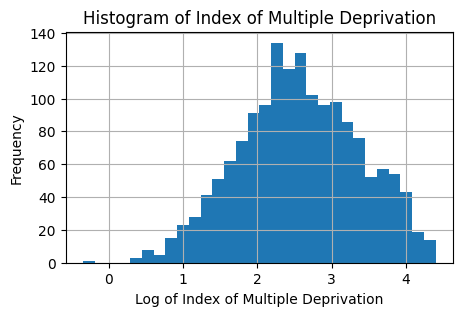

In [37]:
#creating a new column in the imd_df dataframe containing the logarithmized values of IMD scores for each patient
#plotting a histogram to visualise the distribution of patients on the basis of IMD
imd_df['log_imd'] = np.log(imd_df['index_of_multiple_deprivation_england_f26410_0_0'].replace(0, np.nan))

plt.figure(figsize=(5, 3))  # Width and height in inches

# Plot the histogram
imd_df['log_imd'].hist(bins=30)  # You can adjust the number of bins as needed

# Add labels and title
plt.xlabel('Log of Index of Multiple Deprivation')
plt.ylabel('Frequency')
plt.title('Histogram of Index of Multiple Deprivation')

# Show the plot
plt.show()

The code systematically categorizes the index of multiple deprivation column into 'low' and 'high' categories using different percentile cut-offs. Each new column in imd_df represents a different percentile split, providing a variety of ways to classify the data based on deprivation levels. This allows for flexible analysis based on different thresholds of deprivation.

In [38]:
imd_df['0.05, 0.95']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.05,1], labels= ['low', 'high'])
imd_df['0.1, 0.9']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.1,1], labels= ['low', 'high'])
imd_df['0.15, 0.85']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.15,1], labels= ['low', 'high'])
imd_df['0.2, 0.8']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.2,1], labels= ['low', 'high'])
imd_df['0.25, 0.75']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.25,1], labels= ['low', 'high'])
imd_df['0.3, 0.7']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.3,1], labels= ['low', 'high'])
imd_df['0.35, 0.65']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.35,1], labels= ['low', 'high'])
imd_df['0.4, 0.6']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.4,1], labels= ['low', 'high'])
imd_df['0.45, 0.55']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.45,1], labels= ['low', 'high'])
imd_df['0.5, 0.5']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.5,1], labels= ['low', 'high'])
imd_df['0.55, 0.45']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.55,1], labels= ['low', 'high'])
imd_df['0.6, 0.4']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.6,1], labels= ['low', 'high'])
imd_df['0.65, 0.35']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.65,1], labels= ['low', 'high'])
imd_df['0.7, 0.3']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.7,1], labels= ['low', 'high'])
imd_df['0.75, 0.25']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.75,1], labels= ['low', 'high'])
imd_df['0.8, 0.2']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.8,1], labels= ['low', 'high'])
imd_df['0.85, 0.15']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.85,1], labels= ['low', 'high'])
imd_df['0.9, 0.1']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.9,1], labels= ['low', 'high'])
imd_df['0.95, 0.05']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.95,1], labels= ['low', 'high'])

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\4217897725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imd_df['0.05, 0.95']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.05,1], labels= ['low', 'high'])
C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\4217897725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imd_df['0.1, 0.9']= pd.qcut(imd_df['index_of_multiple_deprivation_england_f26410_0_0'], [0,0.1,1], labels= ['low', 'high'])
C:\User

In [39]:
imd_df.columns

Index(['index_of_multiple_deprivation_england_f26410_0_0', 'eid', 'log_imd',
       '0.05, 0.95', '0.1, 0.9', '0.15, 0.85', '0.2, 0.8', '0.25, 0.75',
       '0.3, 0.7', '0.35, 0.65', '0.4, 0.6', '0.45, 0.55', '0.5, 0.5',
       '0.55, 0.45', '0.6, 0.4', '0.65, 0.35', '0.7, 0.3', '0.75, 0.25',
       '0.8, 0.2', '0.85, 0.15', '0.9, 0.1', '0.95, 0.05'],
      dtype='object')

In [40]:
#merging the different split columns from imd_df with the comor_unsub df
comor_unsub = comor_unsub.merge(imd_df[['eid', '0.05, 0.95', '0.1, 0.9', '0.15, 0.85', '0.2, 0.8', '0.25, 0.75','0.3, 0.7', '0.35, 0.65', '0.4, 0.6', '0.45, 0.55', '0.5, 0.5','0.55, 0.45', '0.6, 0.4', '0.65, 0.35', '0.7, 0.3', '0.75, 0.25','0.8, 0.2', '0.85, 0.15', '0.9, 0.1', '0.95, 0.05']], on='eid')

In [41]:
comor_unsub= comor_unsub.set_index('eid')

In [42]:
#extracting the various split columns and storing it in a seperate dataframe to plot the elbow plot
unsub_elbow_df= comor_unsub[comor_unsub.columns[23:44]]

In [43]:
unsub_elbow_df

,age_at_death_f40007_0_0,"0.05, 0.95","0.1, 0.9","0.15, 0.85","0.2, 0.8","0.25, 0.75","0.3, 0.7","0.35, 0.65","0.4, 0.6","0.45, 0.55","0.5, 0.5","0.55, 0.45","0.6, 0.4","0.65, 0.35","0.7, 0.3","0.75, 0.25","0.8, 0.2","0.85, 0.15","0.9, 0.1","0.95, 0.05"
eid,,,,,,,,,,,,,,,,,,,,
1002912,62.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005217,NaN,high,high,high,high,high,high,high,low,low,low,low,low,low,low,low,low,low,low,low
1009538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009715,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006271,70.5,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high
6018053,NaN,high,high,high,high,high,high,high,high,high,high,high,high,high,low,low,low,low,low,low
6020766,75.2,high,high,high,high,high,high,low,low,low,low,low,low,low,low,low,low,low,low,low


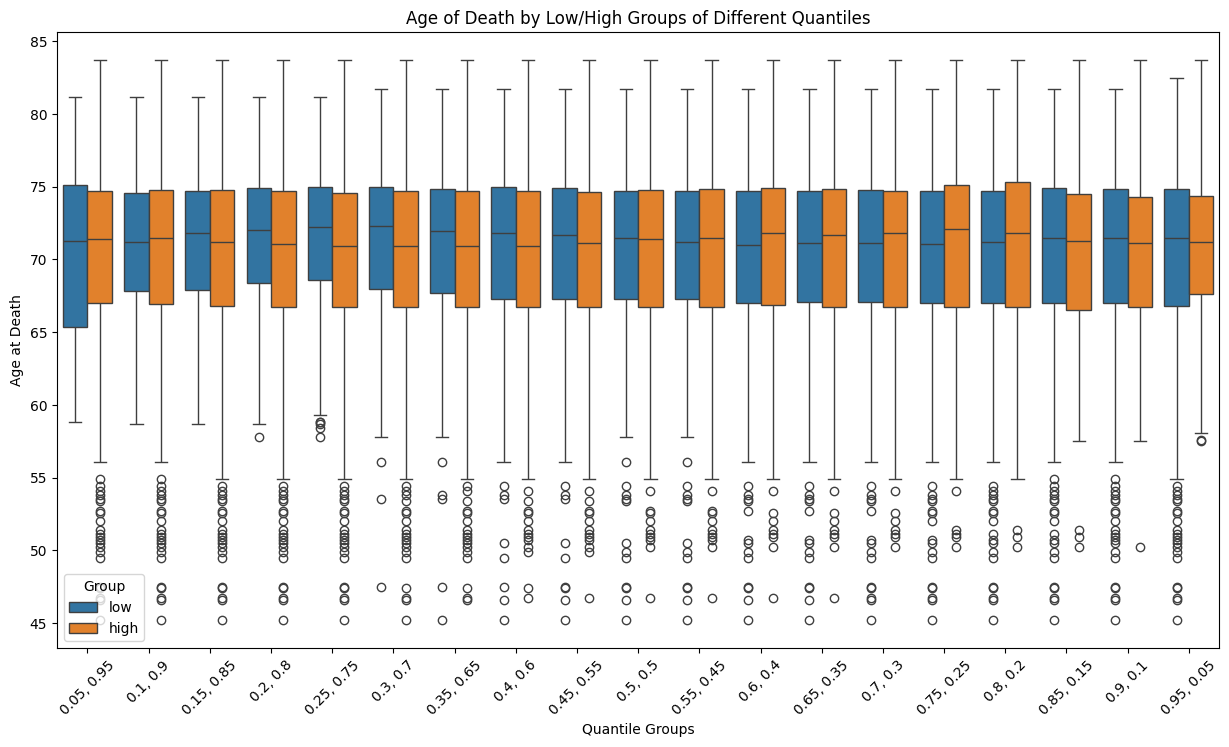

In [44]:
#converting the columns of unsub_elbow_df into rows
#storing it in a new dataframe melted_df
#plotting a multibox plot to visualise the mean longevity difference
melted_df = unsub_elbow_df.melt(id_vars=['age_at_death_f40007_0_0'], var_name='quantile', value_name='group')

melted_df = melted_df.dropna(subset=['age_at_death_f40007_0_0', 'group'])

# Plotting
plt.figure(figsize=(15, 8))
sns.boxplot(data=melted_df, x='quantile', y='age_at_death_f40007_0_0', hue='group')

# Adding title and labels
plt.title('Age of Death by Low/High Groups of Different Quantiles')
plt.xlabel('Quantile Groups')
plt.ylabel('Age at Death')
plt.xticks(rotation=45)
plt.legend(title='Group')

plt.show()

In [45]:
#Calculating the mean age at death for each combination of quantile and group
#Grouping the melted DataFrame by 'quantile' and 'group' columns.
#Calculating the mean of the 'age_at_death_f40007_0_0' column for each group.
#The reset_index() function is used to turn the grouped data back into a DataFrame format.
#Reshaping the DataFrame using the pivot method, where 'quantile' becomes the row index,
#'group' becomes the columns, and the values are the mean ages at death.
#This structure allows for easier comparison between different groups within each quantile.
#Calculating the difference in mean age at death between the 'low' and 'high' groups

In [46]:
grouped_means= melted_df.groupby(['quantile', 'group'])['age_at_death_f40007_0_0'].mean().reset_index()
pivot_table= grouped_means.pivot(index= 'quantile', columns= 'group', values= 'age_at_death_f40007_0_0')
pivot_table['difference']= pivot_table['low']- pivot_table['high']
pivot_table

C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\2901381641.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means= melted_df.groupby(['quantile', 'group'])['age_at_death_f40007_0_0'].mean().reset_index()


group,low,high,difference
quantile,,,
"0.05, 0.95",69.981818,70.322862,-0.341044
"0.1, 0.9",70.442857,70.298352,0.144505
"0.15, 0.85",70.882278,70.222674,0.659604
"0.2, 0.8",71.293694,70.084711,1.208983
"0.25, 0.75",71.481884,69.956455,1.525429
"0.3, 0.7",71.111446,70.000233,1.111213
"0.35, 0.65",70.848958,70.053598,0.795360
"0.4, 0.6",70.485778,70.203514,0.282264
"0.45, 0.55",70.322131,70.301994,0.020137


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_18212\3417582632.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Group')


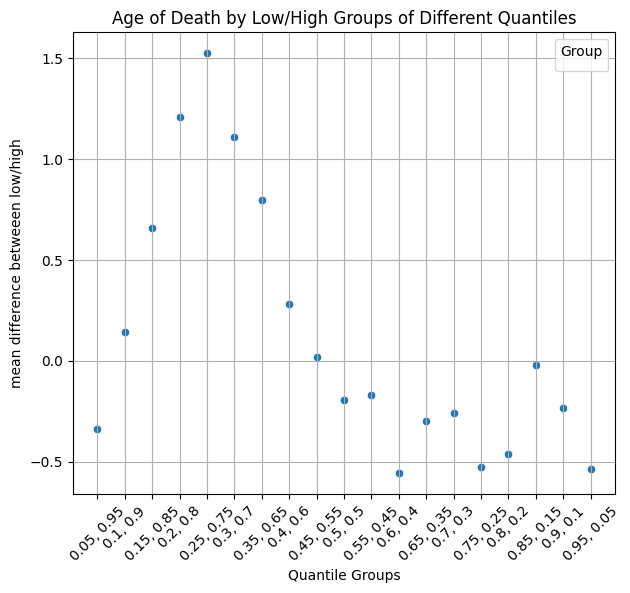

In [47]:
pivot_table
plt.figure(figsize=(7, 6))
sns.scatterplot(data=pivot_table, x='quantile', y='difference')
plt.title('Age of Death by Low/High Groups of Different Quantiles')
plt.xlabel('Quantile Groups')
plt.ylabel('mean difference betweeen low/high')
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.grid(True)
plt.show()